# CEO-Request Challenge

> Should Olist remove underperforming sellers from its marketplace?

## Problem statement

We advise you to start with the following analysis

🕵🏻 **Should Olist remove underperforming sellers from its marketplace ?**

To analyse the impact of removing the worse sellers from Olist's marketplace, we will perform a what-if analysis: What would have happened if Olist had never accepted these sellers in the first place? (granted, it's hard to know in advance who is a good seller, but let's start with this and iterate later).

1️⃣ Compute, for each `seller_id`, and cumulated since the beginning:
- the `revenues` it brings
- the `costs` associated with all its bad reviews
- the resulting `profits` (revenues - costs)
- the number of `orders` (it will impact the overall IT costs)


2️⃣ We can then:
- sort sellers by increasing profits for Olist
- for each number of sellers to remove, compute the financial impact it would have made if they had never been accepted on the platform. 
- we may find an optimal number of sellers to remove that maximizes Olist's profit margin

In [1]:
# Write down a detailed strategy (step by step) to create the DataFrame you need for step 1
# Think about how to re-use or update the logic you have already coded in your `olist` package
# Get matching table
# get seller training data
# get order training date
# get all reviews for each seller and create a dataframe that will be the sum of each reviews for each seller
# compute the total revenue for each seller and add to sellers dataframe
# compute the cost of each seller
# compute the profits

<details>
    <summary>- <i>Hints</i> -</summary>


Starting from your current `seller().get_training_data()` DataFrame, can you easily transform it to compute:
- Olist's positive `revenue_per_seller`? 
- Olist's `cost_of_bad_reviews`?

⚠️ Do no start from scratch ! Investigate your source code in `seller.py` : 

</details>


## Your turn!

## Importing libraries

In [2]:
# Keep this notebook tidy, you will present it orally to Olist CEO on Friday afternoon
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import math
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import plotly.express as px

In [3]:
from olist.order import Order
from olist.seller import Seller
from olist.product import Product
from olist.data import Olist

## Acessando dados do banco de dados

In [4]:
sellers = Seller().get_training_data()
orders = Order().get_training_data(with_distance_seller_customer=True)
products = Product().get_training_data()

In [5]:
categories =  Product().get_product_cat('sum')
categories1 =  Product().get_product_cat('mean')
best_cat = categories[categories.profits > 0].reset_index()['category']
best_prod = products[products['category'].isin(list(best_cat))]['product_id'].drop_duplicates()
best_prod.to_csv('bad_categories.csv', index=False)
best_cat_2 = categories.sort_values('profits').reset_index()['category'][3:]
best_prod_2 = products[products['category'].isin(list(best_cat_2))]['product_id'].drop_duplicates()
best_prod_2.to_csv('bad_categories_2.csv', index=False)

In [6]:
best_products = Seller(best_prod).get_training_data()

In [7]:
best_products_1 = Seller(best_prod_2).get_training_data()

In [8]:
bad_states = pd.read_csv('bad_states.csv').drop_duplicates()
best_products_2 = Seller(bad_states['seller_state']).get_training_data()

In [9]:
total = sellers.sum()[['n_orders','profits']]
total['it_cost'] = 500_000
total['total_profits'] = total['profits'] - total['it_cost']
total['plus_orders'] = 0
total['plus_profits'] = 0


q = total['it_cost'] / math.sqrt(total['n_orders'])
best_categories = best_products.sum()[['n_orders','profits']]
best_categories['it_cost'] = round(q * math.sqrt(best_categories['n_orders']), 2)
best_categories['total_profits'] = best_categories['profits'] - best_categories['it_cost']
best_categories['plus_orders'] = round(best_categories['n_orders'] / total['n_orders'], 2)
best_categories['plus_profits'] = round(best_categories['total_profits'] / total['total_profits'], 2)

best_categories2 = best_products_1.sum()[['n_orders','profits']]
best_categories2['it_cost'] = round(q * math.sqrt(best_categories2['n_orders']), 2)
best_categories2['total_profits'] = best_categories2['profits'] - best_categories2['it_cost']
best_categories2['plus_orders'] = round(best_categories2['n_orders'] / total['n_orders'], 2)
best_categories2['plus_profits'] = round(best_categories2['total_profits'] / total['total_profits'], 2)

best_states = best_products_2.sum()[['n_orders','profits']]
best_states['it_cost'] = round(q * math.sqrt(best_states['n_orders']), 2)
best_states['total_profits'] = best_states['profits'] - best_states['it_cost']
best_states['plus_orders'] = round(best_states['n_orders'] / total['n_orders'], 2)
best_states['plus_profits'] = round(best_states['total_profits'] / total['total_profits'])

best_sellers = sellers[sellers['profits'] > 0].sum()[['n_orders','profits']]
best_sellers['it_cost'] = round(q * math.sqrt(best_sellers['n_orders']), 2)
best_sellers['total_profits'] = best_sellers['profits'] - best_sellers['it_cost']
best_sellers['plus_orders'] = round(best_sellers['n_orders'] / total['n_orders'], 2)
best_sellers['plus_profits'] = round(best_sellers['total_profits'] / total['total_profits'], 2)
result_comparison = pd.concat([total, best_categories, best_categories2, best_states, best_sellers], axis=1)
result_comparison.columns=['total', 'categorias positivas', 'melhores categorias', 'melhores estados', 'melhor vendedor']

Open reviews

In [10]:
data = Olist().get_data()
reviews = data['order_reviews']
reviews1 = reviews[reviews['review_score'] == 1].dropna()
reviews5 = reviews[reviews['review_score'] == 5].dropna()
comment_1 = list(reviews1['review_comment_message'])
comment_5 = list(reviews5['review_comment_message'])

Open Stopwords

In [11]:
from stop_words import get_stop_words

stop_words = get_stop_words('pt')
stop_words.append('produto')
stop_words.append('é')

In [12]:
import re

In [13]:
comment_words1 = ''
for words in comment_1:
    words = words.strip()
    words = re.sub(r'\d', '', words)
    words = words.replace(',', '').replace('.','').replace('/','')
    for word in words.split():
        if word.strip().lower() not in stop_words:
            comment_words1 += "".join(word.strip().lower())+" "
comment_words5 = ''
for words in comment_5:
    words = words.strip()
    words = re.sub(r'\d', '', words)
    words = words.replace(',', '').replace('.','').replace('/','')
    for word in words.split():
        if word.strip().lower() not in stop_words:
            comment_words5 += "".join(word.strip().lower())+" "

In [14]:
from wordcloud import WordCloud, STOPWORDS

In [15]:
wordcloud1 = WordCloud(width = 700, height = 700,
                background_color ='white',
                min_font_size = 10).generate(comment_words1)
wordcloud5 = WordCloud(width = 700, height = 700,
                background_color ='white',
                min_font_size = 10).generate(comment_words5)

### Trabalhando os dados para criar as variáveis

In [16]:
sellers = sellers.sort_values('profits')
N_ORDERS = sellers['n_orders']
PROFITS = sellers['profits']

### Normalizando os valores de ordens para o modelo

In [17]:
columns = ['wait_time', 'expected_wait_time', 'delay_vs_expected',
       'number_of_sellers', 'number_of_products',
       'review_score', 'price', 'freight_value']

In [18]:
orders1 = orders[['review_score','delay_vs_expected','wait_time','number_of_products', 'number_of_sellers', 'distance_seller_customer','price','freight_value']]
orders1['review_score_z'] = (orders1['review_score'] - orders1['review_score'].mean())/ orders1['review_score'].std()
orders1['wait_time_z'] = (orders1['wait_time'] - orders1['wait_time'].mean())/ orders1['wait_time'].std()
orders1['delay_vs_expected_z'] = (orders1['delay_vs_expected'] - orders1['delay_vs_expected'].mean())/ orders1['delay_vs_expected'].std()
orders1['number_of_sellers_z'] = (orders1['number_of_sellers'] - orders1['number_of_sellers'].mean())/ orders1['number_of_sellers'].std()
orders1['price_z'] = (orders1['price'] - orders1['price'].mean())/ orders1['price'].std()
orders1['freight_value_z'] = (orders1['freight_value'] - orders1['freight_value'].mean())/ orders1['freight_value'].std()
orders1['number_of_products_z'] = (orders1['number_of_products'] - orders1['number_of_products'].mean())/ orders1['number_of_products'].std()
orders1['distance_seller_customer_z'] = (orders1['distance_seller_customer'] - orders1['distance_seller_customer'].mean())/ orders1['distance_seller_customer'].std()

# OLIST

# Como reduzir os gastos e maximizar os lucros?

## ANÁLISE BASEADA EM TRÊS HIPÓTESES:

- Vendedores ruins que minimizam o lucro e os reviews
- Tipos de produtos mais suscetíveis e problemas e atrasos
- Regiões do Brasil com mais prejuízos

### Implementando uma política de seleção de vendedores baseadas em resultados!

In [19]:
result_comparison

total categorias positivas melhores categorias  \
n_orders          99844                15022               77640   
profits        683665.6            396990.01           865146.26   
it_cost          500000            193942.46           440911.86   
total_profits  183665.6            203047.55            424234.4   
plus_orders           0                 0.15                0.78   
plus_profits          0                 1.11                2.31   

              melhores estados melhor vendedor  
n_orders                 99449           51655  
profits               687337.0       1278065.4  
it_cost              499009.98       359637.69  
total_profits        188327.02       918427.71  
plus_orders                1.0            0.52  
plus_profits                 1             5.0

# E como se chegou nessa conclusão?

## O QUE MAIS AFETA OS LUCROS DA OLIST?

### O REVIEW SCORE

Como o review score é correlacionado com cada propriedade de um pedido?

<AxesSubplot:>

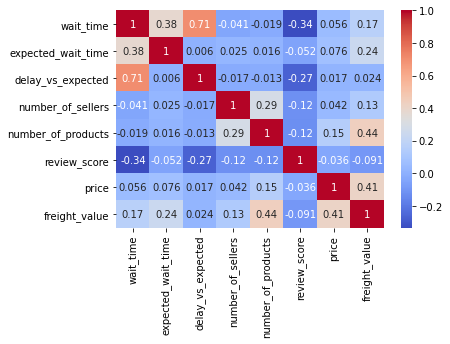

In [23]:
sns.heatmap(orders[columns].corr(), cmap='coolwarm', annot=True)

Relação do review score é maior com:
- número de produtos
- número de vendedores
- tempo de atraso na entrega
- tempo de espera

## Correlacionando essas variáveis...

Aplicando um modelo de regressão nos dados, vemos que há pouca relação entre review score e outras variáveis

In [20]:
model5 = smf.ols(formula='review_score_z ~ wait_time_z + number_of_products_z \
    + distance_seller_customer_z + delay_vs_expected_z', data=orders1).fit()
model5.rsquared

0.13604752362397832

Valor de R muito inferior, o que pode indicar que um fator externo aos pedidos afetam o review score

## TALVEZ O PROBLEMA POSSA ESTAR COM OUTRAS VARIÁVEIS
### Avaliando o texto dos reviews para tentar obter algum padrão

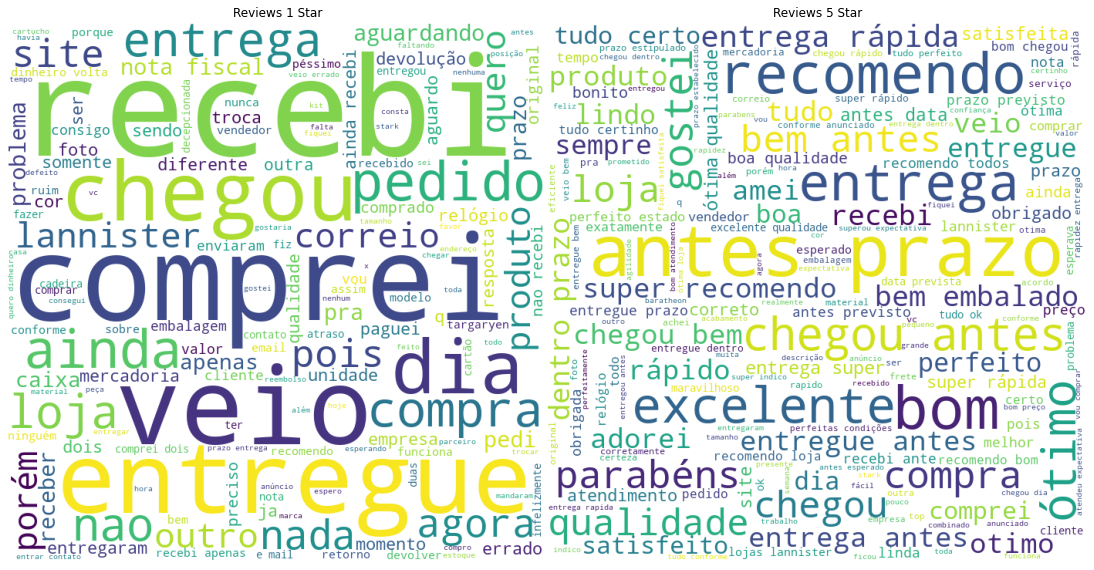

In [21]:
fig, axs = plt.subplots(1,2, figsize=(15,15))
axs[0].imshow(wordcloud1)
axs[0].axis("off")
axs[0].set_title('Reviews 1 Star')
plt.tight_layout(pad = 0)
axs[1].imshow(wordcloud5)
axs[1].axis("off")
axs[1].set_title('Reviews 5 Star')
plt.tight_layout(pad = 0)

## TALVEZ O PROBLEMA POSSA ESTAR COM OS TIPOS DE PRODUTOS

### Vamos comparar categorias, com o tempo de espera e a avaliação

In [22]:
fig = px.scatter(categories1.reset_index(), x="wait_time", y="review_score", size="share_of_one_stars", color="category")
fig.show()

### Verifica-se algumas categorias que tem resultado pior que outras

In [29]:
categories.sort_values('cost', ascending=False, inplace=True)
categories['revenues'] = round(categories['sales'] * 0.1, 2)
categories['cost_vs_revenues'] = round(categories['cost'] / categories['revenues'], 4)
categories[['cost', 'n_orders', 'revenues', 'profits', 'cost_vs_revenues']].sort_values('profits').head()
_.style.applymap(lambda x : 'color: red' if x < 0 else 'color: black')

## Entretanto, aplicando um modelo de regressão, verifica-se que o resultado tem mais relação com o tempo de espera do que com a categoria

In [30]:
model1 = smf.ols(formula = 'review_score ~ wait_time + C(category)', data=products).fit()
results_summary = model1.summary()
results_as_html = results_summary.tables[1].as_html()
pd.read_html(results_as_html, header=0, index_col=0)[0].sort_values('coef').head()

coef  std err      t  \
C(category)[T.security_and_services]             -1.2842    0.791 -1.623   
C(category)[T.furniture_mattress_and_upholstery] -0.4382    0.373 -1.176   
C(category)[T.tablets_printing_image]            -0.2511    0.390 -0.643   
C(category)[T.fashio_female_clothing]            -0.2044    0.253 -0.808   
C(category)[T.fashion_male_clothing]             -0.1660    0.176 -0.945   

                                                  P>|t|  [0.025  0.975]  
C(category)[T.security_and_services]              0.105  -2.835   0.266  
C(category)[T.furniture_mattress_and_upholstery]  0.240  -1.169   0.292  
C(category)[T.tablets_printing_image]             0.520  -1.016   0.514  
C(category)[T.fashio_female_clothing]             0.419  -0.700   0.291  
C(category)[T.fashion_male_clothing]              0.344  -0.510   0.178

Por isso a exclusão de algumas categorias não trouxe grandes diferenças!!!

# AVALIANDO OS VENDEDORES: a chave para o sucesso

<AxesSubplot:xlabel='delay_to_carrier', ylabel='profits'>

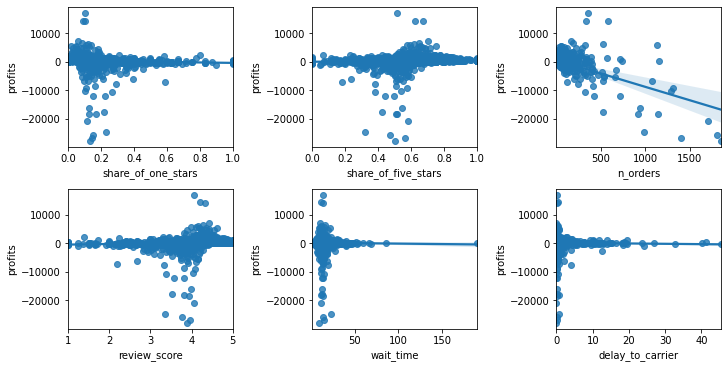

In [31]:
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
gs = fig.add_gridspec(2, 3)
ax1 = fig.add_subplot(gs[0, 0])
sns.regplot(x=sellers['share_of_one_stars'], y=sellers['profits'], ax=ax1)
ax2 = fig.add_subplot(gs[0, 1])
sns.regplot(x=sellers['share_of_five_stars'], y=sellers['profits'], ax=ax2)
ax3 = fig.add_subplot(gs[0, 2])
sns.regplot(x=sellers['n_orders'], y=sellers['profits'], ax=ax3)
ax4 = fig.add_subplot(gs[1, 0])
sns.regplot(x=sellers['review_score'], y=sellers['profits'], ax=ax4)
ax5 = fig.add_subplot(gs[1, 1])
sns.regplot(x=sellers['wait_time'], y=sellers['profits'], ax=ax5)
ax6 = fig.add_subplot(gs[1, 2])
sns.regplot(x=sellers['delay_to_carrier'], y=sellers['profits'], ax=ax6)

## Mas que características do vendedor afetam os lucros?

In [32]:
model = smf.ols(formula = 'profits ~ n_orders', data=sellers).fit()
print(f"numero de ordens: {model.rsquared}")
model = smf.ols(formula = 'profits ~ share_of_one_stars', data=sellers).fit()
print(f"share of one star: {model.rsquared}")
model = smf.ols(formula = 'profits ~ share_of_five_stars', data=sellers).fit()
print(f"share of five star: {model.rsquared}")
model = smf.ols(formula = 'profits ~ review_score', data=sellers).fit()
print(f"review score: {model.rsquared}")
model = smf.ols(formula = 'profits ~ review_score + n_orders', data=sellers).fit()
print(f"review score + numero de ordens: {model.rsquared}")

numero de ordens: 0.3621443382151418
share of one star: 0.008187094440245457
share of five star: 0.005813620722025181
review score: 0.010479023857294822
review score + numero de ordens: 0.37144440578891946


## Uma outra relação que pode ser avaliada são vendas por estados

In [33]:
states = sellers.groupby('seller_state').sum()
states[['wait_time', 'n_orders', 'quantity', 'sales', 'revenues', 'profits']].sort_values('profits').head()

wait_time  n_orders  quantity     sales  revenues  profits
seller_state                                                            
MA            17.825847       392       406  36408.95   4200.90 -3669.10
AM            47.840802         3         3   1177.00    197.70    -2.30
PA            13.427086         8         8   1238.00    443.80   363.80
PI            13.681893        12        12   2522.00    812.20   612.20
RO            32.690481        14        14   4762.20   1356.22  1056.22

## Verifica-se que a exclusão de somente dois estados (MA e AM) altera pouco o resultado final. Então, apesar de ser uma estratégia possível, talves não é indicada ainda neste momento

# Então, e se definirmos metas para os vendedores?

In [34]:
@interact
def plot_polynom(a=widgets.IntSlider(min=0, max=10000, step=1, value=0)):
    print(f"TOTAL - n° orders: {N_ORDERS.sum()}, lucro: R$ {round(PROFITS.sum(), 2)}")
    print(f"ATUALIZADO - n° orders: {N_ORDERS[a:].sum()}, lucro: R$ {round(PROFITS[a:].sum(), 2)}")
    diferença = N_ORDERS.sum() - N_ORDERS[a:].sum()
    percent_orders = ((N_ORDERS.sum() - N_ORDERS[a:].sum())/N_ORDERS.sum())* 100
    percent_profit = ((PROFITS.sum() - PROFITS[a:].sum())/PROFITS.sum())* 100
    print(f"\nDIFERENÇA:\nMENOS {N_ORDERS.sum() - N_ORDERS[a:].sum()} PEDIDOS\nMAIS R$ {round(PROFITS[a:].sum() - PROFITS.sum(), 2)} DE LUCRO")
    print(f"Redução de {percent_orders}% de ordens e variação de {percent_profit}% em ganhos")
    PROFITS.sort_values().reset_index(drop=True)[a:].cumsum().plot()

interactive(children=(IntSlider(value=0, description='a', max=10000), Output()), _dom_classes=('widget-interac…

# Então, chegamos a nossa solução para o aumento dos lucros da empresa: a definição de metas para os vendedores!
## Caso contrário, o vendedor poderá ser retirado da plataforma¶

In [35]:
result_comparison

total categorias positivas melhores categorias  \
n_orders          99844                15022               77640   
profits        683665.6            396990.01           865146.26   
it_cost          500000            193942.46           440911.86   
total_profits  183665.6            203047.55            424234.4   
plus_orders           0                 0.15                0.78   
plus_profits          0                 1.11                2.31   

              melhores estados melhor vendedor  
n_orders                 99449           51655  
profits               687337.0       1278065.4  
it_cost              499009.98       359637.69  
total_profits        188327.02       918427.71  
plus_orders                1.0            0.52  
plus_profits                 1             5.0